In [1]:
from astropy.table import Table
import numpy as np
gaia = Table.read('Gaia.vot')

In [2]:
# load the data to the pandas dataframe
import pandas as pd
df = gaia.to_pandas()
#df.head()
print(df['l'].head())

0    313.058982
1     30.661481
2     68.558197
3     14.585552
4    313.545296
Name: l, dtype: float64


In [3]:
# see the description of the data frame
#df['b'].describe()
#df.info()

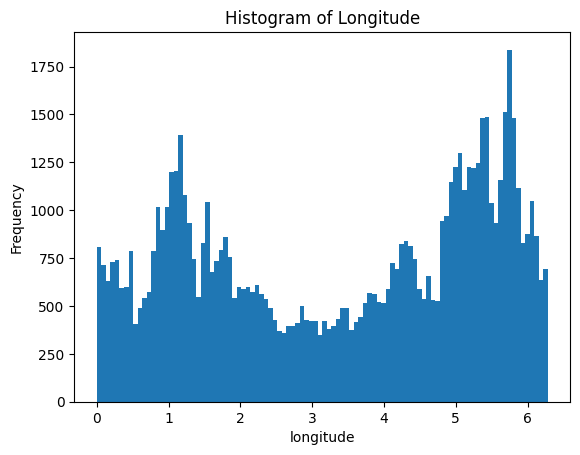

In [4]:
import matplotlib.pyplot as plt
# select the rows that have 'b' (galactic lattitude) less than 5 and greater than -5 (degrees)

bMax = 5
df = df.loc[(df['b'] >= -bMax) & (df['b'] <= bMax)]

# we have some huge relative errors on radial velocity for radial velocity near 0, impose a limit of 20%
RadVelMaxRelError = 0.2
# df = df.loc[(df['radial_velocity_error'] / np.abs(df['radial_velocity'])) <= RadVelMaxRelError]

# convert to radiant, np trigonometric functions require radiants, i'd rather convert once rather than converting every time for calculations
df['l'] = np.deg2rad(df['l'])
plt.hist(df['l'], bins=100)
plt.xlabel('longitude')
plt.ylabel('Frequency')
plt.title('Histogram of Longitude')
plt.show()
df = df.reset_index(drop=True)

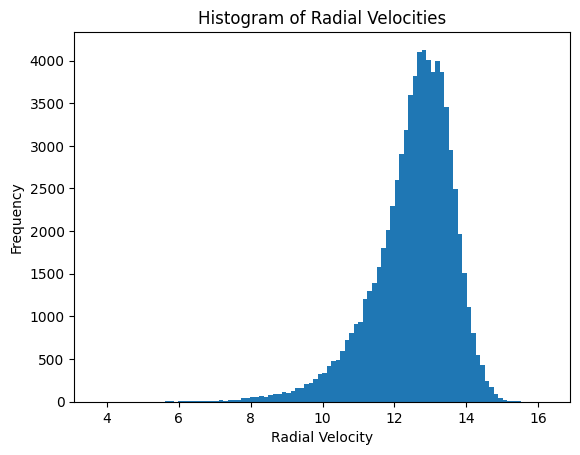

In [5]:
plt.hist(df['phot_g_mean_mag'], bins=100)
plt.xlabel('Radial Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Radial Velocities')
plt.show()

# Important remark
we cannot treat $\sin\varphi$ and  $\cos\varphi$ as independant variables when propagating error of parallax!

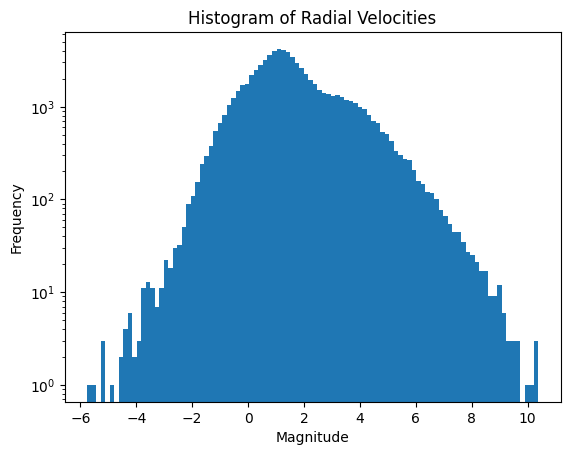

In [6]:
# Calculate distance in parsecs from parallax (milliarcseconds)
df['d'] = 1000 / df['parallax']
df['sigmad'] = 1000 * df['parallax_error'] / (df['parallax']**2)

# compute once and for all sines and cosines of l
df['cosl'] = np.cos(df['l'])
df['sinl'] = np.sin(df['l'])

# Calculate distance from center of galaxy from longitude, R and d
R = 8300
df['D'] = np.sqrt( df['d']**2 + R**2 - 2*df['d']*R*df['cosl'])

# compute sin and cos of phi
df['cosphi'] = (df['d'] * df['cosl'] - R) / df['D'] 
#df['sigmacosphi'] = (df['d']*R*(df['sinl']**2) / (df['D']**3)) * df['sigmad']
df['sinphi'] = (df['d'] * df['sinl']) / df['D']
#df['sigmasinphi'] = np.abs( R*df['sinl']*df['cosphi'] / (df['D']**2))*df['sigmad']

##############################################################################
# Implementation of propagation of error on distance, already propagated from parallax
df['dPropagator'] = (df['sigmad']**2) * (( - df['cosl'] * R*df['sinl']*df['cosphi'] / (df['D']**2)) - (df['sinl']*df['d']*R*(df['sinl']**2) / (df['D']**3)))**2
##############################################################################

#print(df['sigmad'].head(),df['d'].head(),df['parallax'].head(),df['parallax_error'].head())

# plot a histogram of radial velocities with 100 bins
df['M']=df['phot_g_mean_mag']- 5*np.log10(df['d']/10)
plt.hist(df['M'], bins=100)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Radial Velocities')
plt.show()


Text(0, 0.5, 'y [pc]')

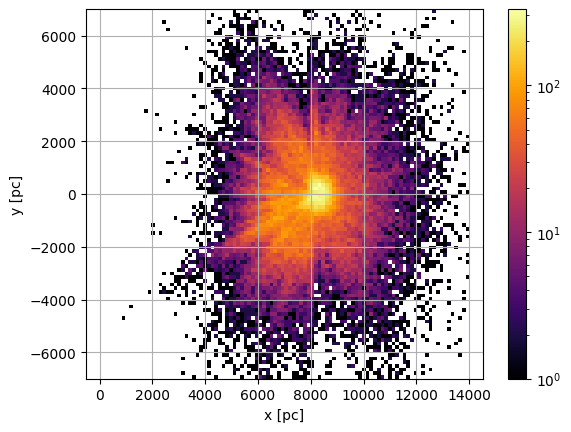

In [ ]:
from matplotlib.colors import LogNorm
dfmag = df.loc[(df['M'] <= 4)]

plt.hist2d(-df['D']*df['cosphi'], df['D']*df['sinphi'], bins = (100, 100), norm=LogNorm(), range=((0, 14000), (-7000, 7000)), cmap = "inferno")
plt.gca().set_aspect('equal', adjustable='box') # endure square grid
plt.grid()

plt.colorbar()
plt.axis('equal')
plt.xlabel(r"x [pc]")
plt.ylabel("y [pc]")

Text(0, 0.5, 'l [rad]')

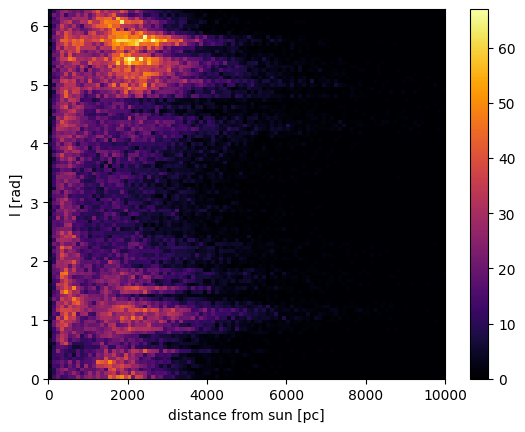

In [9]:
# where are the stars in terms of radial distance and l?

PhiMax = 2*np.pi

plt.hist2d(df['d'], df['l'], bins = (100, 100), range=((0, 10000), (0, PhiMax)), cmap = "inferno")
plt.colorbar()
plt.xlabel("distance from sun [pc]")
plt.ylabel("l [rad]")

Text(0, 0.5, 'relative error on distance [a.u.]')

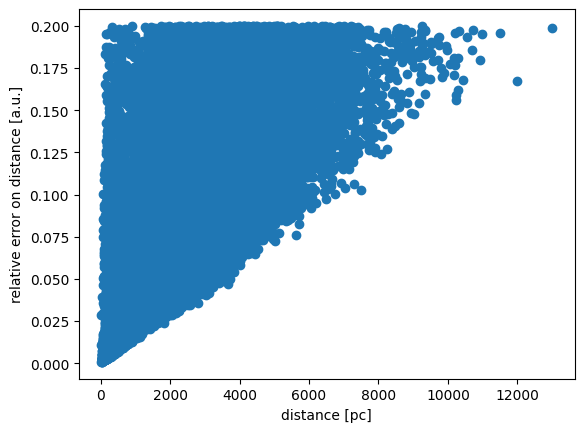

In [10]:
# how are the relative errors distributed?
# by error propagation, the relative error on the parallax is equal to that on the distance
plt.scatter(df['d'], df['parallax_error'] / df['parallax'])
plt.xlabel("distance [pc]")
plt.ylabel("relative error on distance [a.u.]")

Text(0, 0.5, 'relative error on radial velocity')

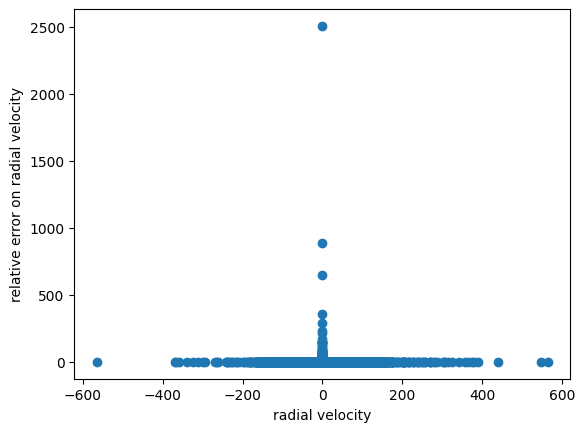

In [11]:
plt.scatter(df['radial_velocity'], df['radial_velocity_error'] / np.abs(df['radial_velocity']))
plt.xlabel('radial velocity')
plt.ylabel('relative error on radial velocity')

In [12]:
VrotTry = 205
uTry = 11.7
vTry = 22

VarIntrinsicTry = 937

df['vModTry'] = v_mod([VrotTry, uTry, vTry, VarIntrinsicTry], df['sinl'], df['cosl'], df['D'])

plt.hist(df['vModTry']-df['radial_velocity'], bins=1000, density=True);
plt.xlim(-200, 200)


mu, sigma = norm.fit(df['vModTry']-df['radial_velocity'])
plt.plot(np.linspace(-200, 200, 100), norm.pdf(np.linspace(-200, 200, 100), mu, sigma))

print("Fit Parameters: mu = {:.2f}, var = {:.2f}".format(mu, sigma**2))
print("LogPrior: {:.2f}".format(log_prior([VrotTry, uTry, vTry, VarIntrinsicTry])))
print("LogLike: {:.2f}".format(log_like([VrotTry, uTry, vTry, VarIntrinsicTry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))
print("LogProb: {:.2f}".format(log_prob([VrotTry, uTry, vTry, VarIntrinsicTry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))
print("Average varrad: {:.2f}".format(np.mean(df['VAR_rad_vel'])))
print("Average prop*vrot**2: {:.2f}".format(np.mean(df['DER2_Prop_model'])*VrotTry**2))

NameError: name 'v_mod' is not defined

Text(0, 0.5, 'difference in vrad [Km/s]')

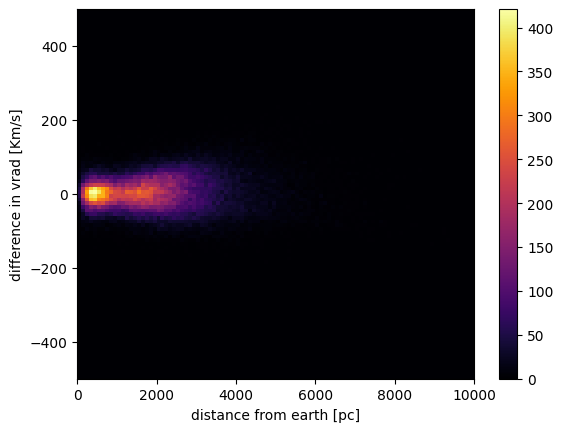

In [ ]:
plt.hist2d(df['d'], df['vradDiff'], bins = (100, 100), range=((0, 10000), (-500, 500)), cmap = "inferno");
plt.colorbar()
plt.xlabel("distance from earth [pc]")
plt.ylabel("difference in vrad [Km/s]")


Text(0, 0.5, 'difference in vrad [Km/s]')

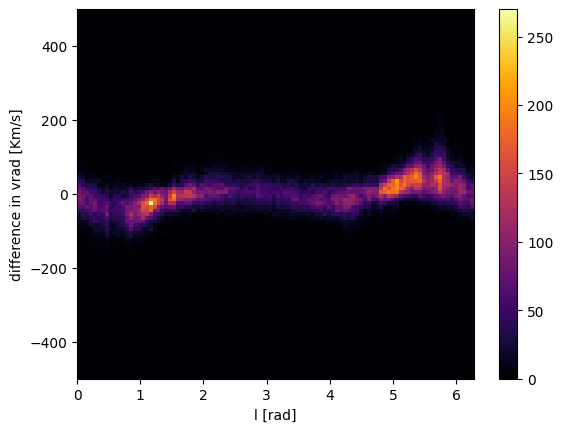

In [ ]:
plt.hist2d(df['l'], df['vradDiff'], bins = (100, 100), range=((0, 2*np.pi), (-500, 500)), cmap = "inferno");
plt.colorbar()
plt.xlabel("l [rad]")
plt.ylabel("difference in vrad [Km/s]")

/tmp/ipykernel_1254/3288398337.py:14: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")
/tmp/ipykernel_1254/3288398337.py:14: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")


Text(0.5, 1.0, 'Contour plot of log(vradDiff) as a function of d and l')

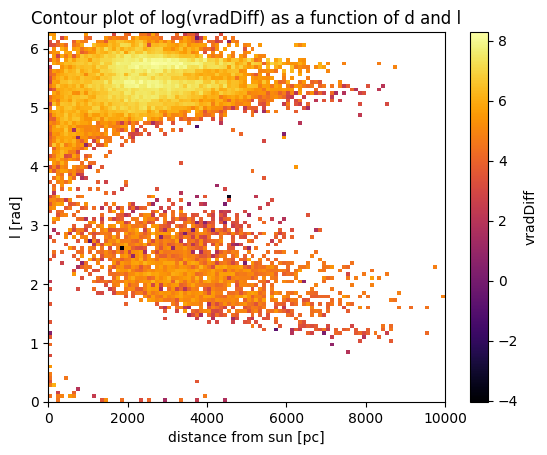

In [ ]:
# Create a contour plot of vradDiff as a function of d and l
d_values = df['d']
l_values = df['l']
vrad_diff_values = df['vradDiff']

# Create a 2D histogram for contour plotting
hist, xedges, yedges = np.histogram2d(d_values, l_values, bins=(100, 100), range=((0, 10000), (0, 2 * np.pi)), weights=vrad_diff_values)

# Compute the bin centers
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

# Create the contour plot
plt.pcolormesh(xcenters, ycenters, np.log(hist.T),  cmap="inferno")
plt.colorbar(label="vradDiff")
plt.xlabel("distance from sun [pc]")
plt.ylabel("l [rad]")
plt.title("Contour plot of log(vradDiff) as a function of d and l")


I think this implementation of propagation is not correct, as it treates independantely cosphi and sinphi, see above cells for df['dPropagator']

In [ ]:
# variance on difference, for now, just use error on vrad, bu errors on parallax must be propagated
# df['propagation'] = (df['cosl']**2)*(df['sigmasinphi']**2) + (df['sinl']**2)*(df['sigmacosphi']**2)
df['var'] = df['radial_velocity_error']**2

print(df['dPropagator'].head())
print(df['var'].head())

0    0.000024
1    0.000015
2    0.000209
3    0.005240
4    0.000049
Name: dPropagator, dtype: float64
0    5.391734
1    1.695116
2    3.567839
3    0.633628
4    7.094703
Name: var, dtype: float64


In [ ]:
# log likelyhood 
def log_like(par,vrad,var,prop,sinl,cosl,sinphi,cosphi):
    vrot,u,v=par
    return -0.5*( np.sum( (vrad - vrot*( sinphi*cosl - (1 + cosphi)*sinl) - u*cosl - v*sinl)**2 /(var + (vrot**2)*prop) + np.log(var + (vrot**2)*prop) ) )

#tipical star motion in galaxies
vgal=200

# log prior
def log_prior(par):
    vrot,u,v=par
    if not -500<=vrot<=500:
        return -np.inf
    if not -500<=u<=500:
        return -np.inf
    if not -500<=v<=500:
        return -np.inf

    return -0.5*(u**2+v**2)/vgal**2 - np.log(np.abs(vrot)) 

# log prob
def log_prob(par,vrad,var,prop,sinl,cosl,sinphi,cosphi):
    lp=log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(par,vrad,var,prop,sinl,cosl,sinphi,cosphi)

In [ ]:
import emcee

ndim = 3  
nwalkers = 12
nsteps = 1000 
burnin = 100

# Valori iniziali casuali per i walker
p0 = np.random.randn(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(df['radial_velocity'], df['var'], df['dPropagator'], df['sinl'], df['cosl'], df['sinphi'], df['cosphi']))

sampler.run_mcmc(p0, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

print("Forma dei campioni:", flat_samples.shape)


100%|██████████| 1000/1000 [00:29<00:00, 34.17it/s]

Forma dei campioni: (1080, 3)


Text(0.5, 0, 'step number')

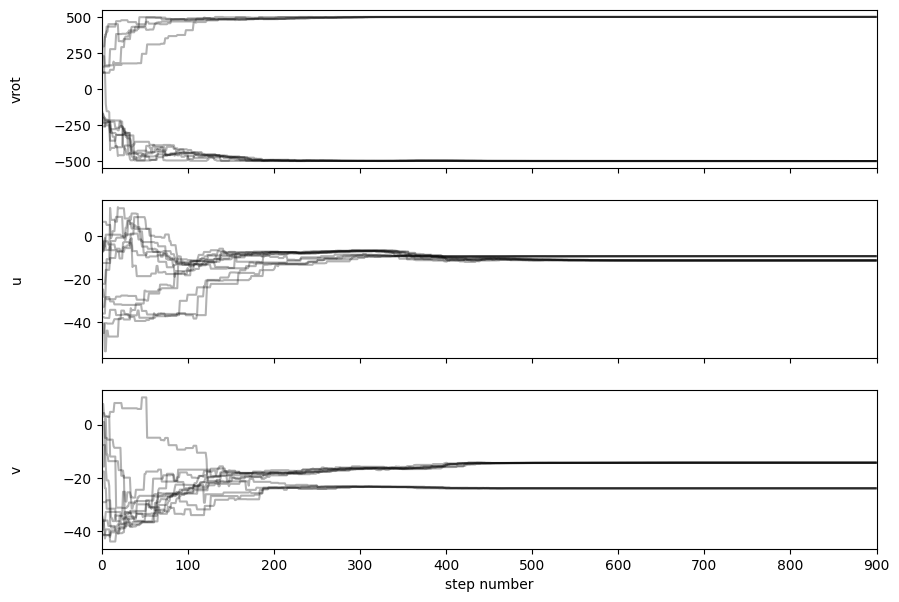

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
labels = ["vrot", "u", "v"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

(1080, 3)


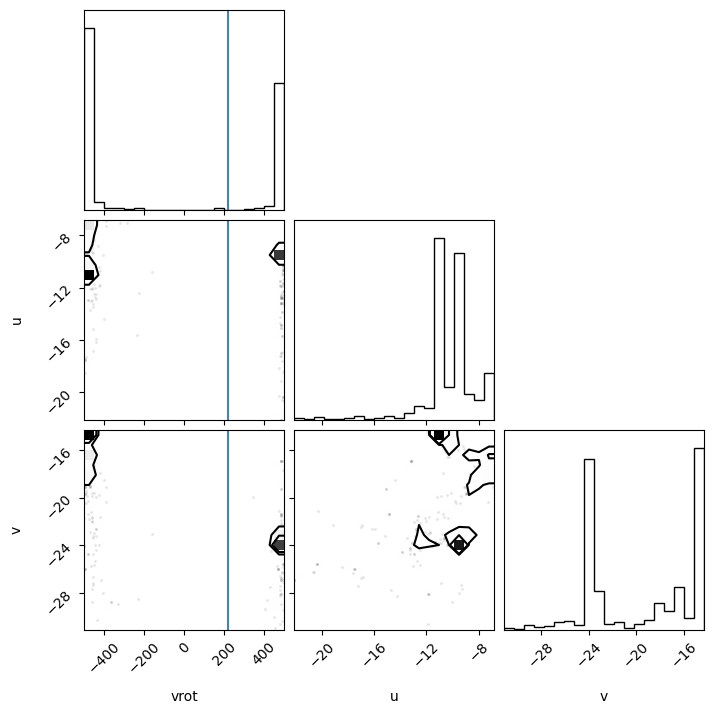

In [ ]:
import corner
# Compute the 5th and 95th percentiles for each parameter
ranges = []
for i in range(flat_samples.shape[1]):  # Iterate over dimensions
    lower, upper = np.percentile(flat_samples[:, i], [5, 95])
    ranges.append((lower, upper))

print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, range=ranges, truths=[220, 10, 10])